In [1]:
import os
from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
np.random.seed(2455)
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import albumentations as A

## 이미지 Aug & Mix 복사

In [2]:
def save_img(path, img) :
    extension = ".png"#os.path.splitext(path)[1] # 이미지 확장자
    result, encoded_img = cv2.imencode(extension, img)
    
    if result:
        with open(path, mode='w+b') as f:
            encoded_img.tofile(f)

    
def load_img(path) :
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img
    # return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


## Aug 적용 전 데이터 개수

In [21]:
path = './data/train/*'
label_dict = []
for p in glob(path):
    label_name = p.split("\\")[-1]
    label_cnt = len([_p for _p in glob(p+"/*") if "_aug_" not in _p])
    label_dict.append([label_name, label_cnt])
    
label_dict = sorted(label_dict, key=lambda x:x[-1])
for k, v in label_dict :
    print(k + " : " + str(v))



반점 : 3
틈새과다 : 5
가구수정 : 12
녹오염 : 14
이음부불량 : 17
울음 : 22
창틀,문틀수정 : 27
피스 : 51
들뜸 : 54
석고수정 : 57
면불량 : 99
몰딩수정 : 130
오타공 : 142
곰팡이 : 145
터짐 : 162
꼬임 : 210
걸레받이수정 : 307
오염 : 595
훼손 : 1405


### 반점
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [4]:
transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.RandomGridShuffle(),
    A.ColorJitter(),
    A.RandomSunFlare(src_radius=200),
    A.ToGray(p=0.5),
    # A.ToSepia(),
    A.GridDistortion(),
    A.Perspective(p=1),
    # A.Spatter(intensity=0.3, p=1)
])

##### augmentations 180장

In [6]:
# path = "./data/train/반점/*"
# img_list = glob(path)
path = './data/train/*'
curr_label = "반점"
img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]

num_aug = 75
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list :
        img = load_img(p)
        img = transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
        # cv2.imwrite(save_path, img)
        save_img(save_path, img)
        
        


100%|██████████| 75/75 [00:05<00:00, 12.70it/s]


##### mixup 162장
- 각 클래스에서 3장씩 샘플링

In [37]:
# transforms = A.Compose([
#     A.Rotate(p=1),
#     A.OneOf([
#         A.HorizontalFlip(),
#         A.VerticalFlip(),
#     ],p = 0.5),
#     A.ColorJitter(),
# ])

In [38]:
# path = './data/train/*'
# curr_label = "반점"
# num_sample = 3

# folder_list = [p for p in glob(path) if curr_label not in p]
# smapling_img_list = []
# for idx, f in enumerate(folder_list) :
#     img_list = glob(os.path.join(f, '*'))
#     sampling = np.random.choice(len(img_list), num_sample, replace=False)
#     smapling_img_list.extend(np.array(img_list)[sampling].tolist())

In [40]:
# curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
# for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
#     for c_idx, curr_img_path in enumerate(curr_img_list) :
#         samp_img = load_img(sampling_img_path)
#         curr_img = transforms(image=load_img(curr_img_path))['image']
        
#         samp_img = cv2.resize(samp_img, (600, 600))
#         curr_img = cv2.resize(curr_img, (600, 600))
        
#         img = cv2.addWeighted(curr_img, 0.85, samp_img, 0.15, 0)
        
#         save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
#         save_img(save_path, img)

100%|██████████| 54/54 [00:04<00:00, 12.19it/s]


### 틈새과다
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [8]:
aug_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.GlassBlur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    A.FancyPCA(p=0.1),
    A.ToGray(p=0.5),
    A.Emboss(),
    A.GridDistortion(),
    A.Perspective(p=1),
    A.RandomShadow(p=0.3),    
    A.RandomCrop(height=550, width=500, p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.ColorJitter(),
])


##### augmentation 200장

In [9]:
# path = "./data/train/틈새과다/*"
# img_list = glob(path)

path = "./data/train/*"
curr_label = "틈새과다"
img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]

num_aug = 55
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
        # plt.imshow(img)
    
        save_img(save_path, img)
        
        


100%|██████████| 55/55 [00:14<00:00,  3.87it/s]


##### mixup 180장
- 각 클래스에서 2장씩 샘플링

In [258]:
# path = './data/train/*'
# curr_label = "틈새과다"
# num_sample = 2

# folder_list = [p for p in glob(path) if curr_label not in p]
# smapling_img_list = []
# for idx, f in enumerate(folder_list) :
#     img_list = glob(os.path.join(f, '*'))
#     sampling = np.random.choice(len(img_list), num_sample, replace=False)
#     smapling_img_list.extend(np.array(img_list)[sampling].tolist())

In [259]:
# curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
# for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
#     for c_idx, curr_img_path in enumerate(curr_img_list) :
#         samp_img = load_img(sampling_img_path)
#         curr_img = transforms(image=load_img(curr_img_path))['image']
        
#         samp_img = cv2.resize(samp_img, (600, 600))
#         curr_img = cv2.resize(curr_img, (600, 600))
        
#         img = cv2.addWeighted(curr_img, 0.7, samp_img, 0.3, 0)
        
#         save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
#         save_img(save_path, img)
        

100%|██████████| 36/36 [00:05<00:00,  7.12it/s]


### 가구수정 
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [11]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.GlassBlur(),
    # A.ColorJitter(),
    # A.ChannelShuffle(),
    # A.FancyPCA(p=0.1),
    # A.ToGray(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(),
    A.Perspective(p=1),
    A.RandomShadow(p=0.3),    
    A.RandomCrop(height=550, width=500, p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.ColorJitter(),
])


##### augmentation 120장
- 각 클래스에서 3장씩 샘플링

100%|██████████| 25/25 [00:05<00:00,  4.24it/s]


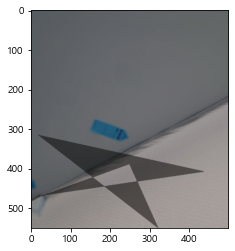

In [12]:
# path = "./data/train/가구수정/*"
# img_list = glob(path)

path = "./data/train/*"
curr_label = "가구수정"
img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]

num_aug = 25
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
        plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


##### mixup 216장
- 각 클래스에서 1장씩 샘플링

In [572]:
# path = './data/train/*'
# curr_label = "가구수정"
# num_sample = 1

# folder_list = [p for p in glob(path) if curr_label not in p]
# smapling_img_list = []
# for idx, f in enumerate(folder_list) :
#     img_list = glob(os.path.join(f, '*'))
#     sampling = np.random.choice(len(img_list), num_sample, replace=False)
#     smapling_img_list.extend(np.array(img_list)[sampling].tolist())
    
# curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
# for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
#     for c_idx, curr_img_path in enumerate(curr_img_list) :
#         samp_img = load_img(sampling_img_path)
#         curr_img = transforms(image=load_img(curr_img_path))['image']
        
#         samp_img = cv2.resize(samp_img, (600, 600))
#         curr_img = cv2.resize(curr_img, (600, 600))
        
#         img = cv2.addWeighted(curr_img, 0.8, samp_img, 0.2, 0)
        
#         save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
#         save_img(save_path, img)
        

100%|██████████| 18/18 [00:05<00:00,  3.24it/s]


### 녹오염 
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [13]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.GlassBlur(),
    # A.ColorJitter(),
    # A.ChannelShuffle(),
    A.RandomGridShuffle((2,2), p=1),
    # A.ToGray(p=0.5),
    # A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=1),
    A.Perspective(p=1),
    A.RandomShadow(p=0.3),    
    A.RandomCrop(height=570, width=570, p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
])


##### augmentations 112장

In [15]:
# path = "./data/train/녹오염/*"
# img_list = glob(path)

path = "./data/train/*"
curr_label = "녹오염"
img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]

num_aug = 16
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
        # plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 16/16 [00:10<00:00,  1.57it/s]


##### mixup 252장
- 각 클래스에서 3장씩 샘플링

In [896]:
# path = './data/train/*'
# curr_label = "녹오염"
# num_sample = 1

# folder_list = [p for p in glob(path) if curr_label not in p]
# smapling_img_list = []
# for idx, f in enumerate(folder_list) :
#     img_list = glob(os.path.join(f, '*'))
#     sampling = np.random.choice(len(img_list), num_sample, replace=False)
#     smapling_img_list.extend(np.array(img_list)[sampling].tolist())
    
# curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
# for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
#     for c_idx, curr_img_path in enumerate(curr_img_list) :
#         samp_img = load_img(sampling_img_path)
#         curr_img = mix_transforms(image=load_img(curr_img_path))['image']
        
#         samp_img = cv2.resize(samp_img, (600, 600))
#         curr_img = cv2.resize(curr_img, (600, 600))
        
#         img = cv2.addWeighted(curr_img, 0.7, samp_img, 0.3, 0)
        
#         save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
#         save_img(save_path, img)
        

100%|██████████| 18/18 [00:06<00:00,  2.79it/s]


### 이음부불량 
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [16]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.GlassBlur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 162장m
- 각 클래스에서 3장씩 샘플링

In [17]:
# path = "./data/train/이음부불량/*"
# img_list = glob(path)

path = "./data/train/*"
curr_label = "이음부불량"
img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]

num_aug = 18
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list[1:]:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 18/18 [00:04<00:00,  3.65it/s]


##### mixup 306장
- 각 클래스에서 1장씩 샘플링

In [984]:
# path = './data/train/*'
# curr_label = "이음부불량"
# num_sample = 1

# folder_list = [p for p in glob(path) if curr_label not in p]
# smapling_img_list = []
# for idx, f in enumerate(folder_list) :
#     img_list = glob(os.path.join(f, '*'))
#     sampling = np.random.choice(len(img_list), num_sample, replace=False)
#     smapling_img_list.extend(np.array(img_list)[sampling].tolist())
    
# curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
# for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
#     for c_idx, curr_img_path in enumerate(curr_img_list) :
#         samp_img = load_img(sampling_img_path)
#         curr_img = mix_transforms(image=load_img(curr_img_path))['image']
        
#         samp_img = cv2.resize(samp_img, (600, 600))
#         curr_img = cv2.resize(curr_img, (600, 600))
        
#         img = cv2.addWeighted(curr_img, 0.8, samp_img, 0.2, 0)
        
#         save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
#         save_img(save_path, img)
        

100%|██████████| 18/18 [00:07<00:00,  2.36it/s]


### 울음
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [18]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.GlassBlur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### augmentation 220장
- 각 클래스에서 3장씩 샘플링

In [19]:
# path = "./data/train/울음/*"
# img_list = glob(path)

path = "./data/train/*"
curr_label = "울음"
img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]

num_aug = 16
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


##### mixup 220장
- 각 클래스에서 3장씩 샘플링

In [1224]:
# path = './data/train/*'
# curr_label = "울음"
# num_sample = 1

# folder_list = [p for p in glob(path) if curr_label not in p]
# smapling_img_list = []
# for idx, f in enumerate(folder_list) :
#     if np.random.binomial(n=1, p=0.5, size=1)[0] :
#         img_list = glob(os.path.join(f, '*'))
#         sampling = np.random.choice(len(img_list), num_sample, replace=False)
#         smapling_img_list.extend(np.array(img_list)[sampling].tolist())
    
# curr_img_list = [i for i in glob(os.path.join(path[:-1], curr_label, '*')) if "_" not in i]
# for s_idx, sampling_img_path in enumerate(tqdm(smapling_img_list)) :
#     for c_idx, curr_img_path in enumerate(curr_img_list) :
#         samp_img = load_img(sampling_img_path)
#         curr_img = mix_transforms(image=load_img(curr_img_path))['image']
        
#         samp_img = cv2.resize(samp_img, (600, 600))
#         curr_img = cv2.resize(curr_img, (600, 600))
        
#         img = cv2.addWeighted(curr_img, 0.85, samp_img, 0.15, 0)
        
#         save_path = os.path.join(curr_img_path.split('\\')[-2], str(s_idx) + "_mix_" + curr_img_path.split("\\")[-1])
        
#         save_img(save_path, img)
        

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


### 창틀,문틀수정
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1291]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    A.ColorJitter(),
    # A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    # A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=0.5),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    # A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 210장
- 각 클래스에서 3장씩 샘플링

In [1295]:
path = "./data/train/창틀,문틀수정/*"
img_list = glob(path)

num_aug = 15
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list[13:]:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


### 피스
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1407]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.Blur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=0.5),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    # A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 255 장
- 각 클래스에서 3장씩 샘플링

In [1451]:
path = "./data/train/피스/*"
img_list = glob(path)

num_aug = 5
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


### 들뜸
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1535]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    A.ColorJitter(),
    A.ChannelShuffle(),
    # A.RandomGridShuffle((2,2), p=1),
    A.ToGray(p=0.5),
    A.ToSepia(p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    # A.GridDistortion(p=0.5),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.3),    
    # A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    # A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 270 장
- 각 클래스에서 3장씩 샘플링

In [1536]:
path = "./data/train/들뜸/*"
img_list = glob(path)

num_aug = 5
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


### 석고수정
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1687]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    
    A.ColorJitter(),
    # A.ChannelShuffle(),
    A.OneOf([
        A.ToGray(p=0.5),
        A.ToSepia(p=0.5)
    ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    # A.Equalize(by_channels=False,p=0.3),
    # A.RGBShift(p=1),
    # A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 285장
- 각 클래스에서 3장씩 샘플링b

In [1688]:
path = "./data/train/석고수정/*"
img_list = glob(path)

num_aug = 5
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


### 면불량
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1698]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    
    # A.ColorJitter(),
    # A.ChannelShuffle(),
    A.OneOf([
        A.ToGray(p=0.5),
        A.ToSepia(p=0.5)
    ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    # A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 198장
- 각 클래스에서 3장씩 샘플링

In [1747]:
path = "./data/train/면불량/*"
img_list = glob(path)

num_aug = 2
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


### 몰딩수정
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1760]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    
    A.ColorJitter(),
    # A.ChannelShuffle(),
    # A.OneOf([
    #     A.ToGray(p=0.5),
    #     A.ToSepia(p=0.5)
    # ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    A.RandomShadow(p=0.5),    
    # A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 130장
- 각 클래스에서 3장씩 샘플링

In [1796]:
path = "./data/train/몰딩수정/*"
img_list = glob(path)

num_aug = 1
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


### 오타공
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1840]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    A.Blur(),
    
    A.ColorJitter(),
    A.ChannelShuffle(),
    A.OneOf([
        A.ToGray(p=0.5),
        A.ToSepia(p=0.5)
    ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    # A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
    A.PiecewiseAffine(p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 126장
- 각 클래스에서 3장씩 샘플링

In [1853]:
path = "./data/train/오타공/*"
img_list = glob(path)

num_aug = 1
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list[16:]:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 1/1 [00:23<00:00, 23.93s/it]


### 곰팡이
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1894]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.Blur(),
    
    # A.ColorJitter(),
    A.ChannelShuffle(),
    # A.OneOf([
        # A.ToGray(p=1),
        # A.ToSepia(p=0.5)
    # ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    # A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
    # A.PiecewiseAffine(p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 145장
- 각 클래스에서 3장씩 샘플링

In [1914]:
path = "./data/train/곰팡이/*"
img_list = glob(path)

num_aug = 1
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 1/1 [00:03<00:00,  3.47s/it]


### 터짐
#### 적용 리스트
- 회전, 뒤집기, 그리드스플릿, 색반전, Mixup

In [1947]:
aug_transforms = A.Compose([
    A.Resize(600, 600, p=1),
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.Blur(),
    
    # A.ColorJitter(),
    A.ChannelShuffle(),
    # A.OneOf([
        # A.ToGray(p=1),
        # A.ToSepia(p=0.5)
    # ],p=0.5),
    # A.RandomGridShuffle((2,2), p=0.5),
    A.RandomBrightnessContrast(brightness_by_max=False,p=1),
    A.GridDistortion(p=1),
    A.Perspective(p=1),
    # A.RandomShadow(p=0.5),    
    A.Equalize(by_channels=False,p=1),
    # A.RGBShift(p=1),
    A.RandomCrop(height=570, width=570, p=1),
    A.Posterize(num_bits=8, p=1),
    # A.PiecewiseAffine(p=1)
])

mix_transforms = A.Compose([
    A.Rotate(p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
    ],p = 0.5),
    # A.ColorJitter(),
    A.Posterize(p=1),

])



##### mixup 162장
- 각 클래스에서 3장씩 샘플링

In [1949]:
path = "./data/train/터짐/*"
img_list = glob(path)

num_aug = 1
for idx, n in enumerate(tqdm(range(num_aug))) :
    for p in img_list:
    
        img = load_img(p)
        img = aug_transforms(image=img)['image']
        
        save_path = os.path.join(p.split('\\')[-2], str(idx) + "_aug_" + p.split("\\")[-1])
        
    #     plt.imshow(img)
    #     break
    # break
        save_img(save_path, img)
        
        


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


### Aug 적용 후 데이터 개수

In [28]:
path = './data/train/*'
glob(path)
label_dict = []
for p in glob(path):
    label_name = p.split("\\")[-1]
    label_cnt = len(glob(p+"/*"))
    label_dict.append([label_name, label_cnt])
    
label_dict = sorted(label_dict, key=lambda x:x[-1])
for k, v in label_dict :
    print(k + " : " + str(v))


꼬임 : 210
반점 : 228
창틀,문틀수정 : 237
녹오염 : 238
몰딩수정 : 260
오타공 : 268
틈새과다 : 280
곰팡이 : 290
면불량 : 297
이음부불량 : 305
피스 : 306
걸레받이수정 : 307
가구수정 : 312
들뜸 : 324
터짐 : 324
석고수정 : 342
울음 : 374
오염 : 595
훼손 : 1405


# 실험

In [23]:
def aug(transforms) :
    path = './data/train/*'
    folder_list = glob(path)
    f, axs = plt.subplots(len(folder_list), 1, figsize=(10, 70))
    axs = axs.flatten()
    num_sample = 1
    smapling_img_list = []
    for idx, f in enumerate(folder_list) :
        img_list = glob(os.path.join(f, '*'))
        sampling = np.random.choice(len(img_list), num_sample, replace=False)
        smapling_img_list.extend(np.array(img_list)[sampling].tolist())

    for idx ,p in enumerate(smapling_img_list) :
        img_array = np.fromfile(p, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        # img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        img = transforms(image=img)['image']
        axs[idx].imshow(img)
        axs[idx].set_title(p.split('\\')[-2])
        

    plt.show()


## Augmentation 실험 - grayscale

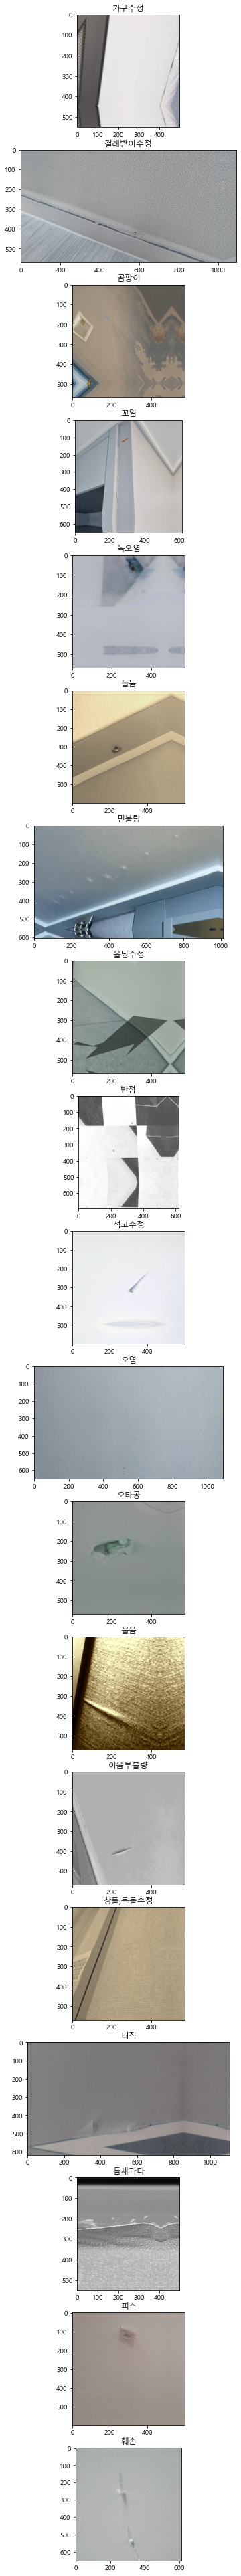

In [24]:
transforms = A.Compose([
    A.GridDistortion(p=1, 
                        always_apply=False, 
                        num_steps=1, 
                        # img 굴곡 조정
                        distort_limit=(-0.1, 0.3), 
                        interpolation=2, 
                        border_mode=2, 
                        value=(0, 0, 0), 
                        mask_value=None)
])

aug(transforms)

## 기타

In [62]:
glob("./data/train/*")

['./data/train\\가구수정',
 './data/train\\걸레받이수정',
 './data/train\\곰팡이',
 './data/train\\꼬임',
 './data/train\\녹오염',
 './data/train\\들뜸',
 './data/train\\면불량',
 './data/train\\몰딩수정',
 './data/train\\반점',
 './data/train\\석고수정',
 './data/train\\오염',
 './data/train\\오타공',
 './data/train\\울음',
 './data/train\\이음부불량',
 './data/train\\창틀,문틀수정',
 './data/train\\터짐',
 './data/train\\틈새과다',
 './data/train\\피스',
 './data/train\\훼손']

In [60]:
import timm
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnex

In [61]:
a = [1,23]

isinstance(a, list)

True

In [34]:
import os
p = r"C:\\Users\\quhb2\\Documents\\git\\toy\\Interior_classification\\data\\train\\꼬임\\0.png"
# os.path.splitext(p)
os.path.splitext(os.path.basename(p))[0]

'0'

In [40]:
def a (**agrs) :
    print(agrs)
    
z = {"asdf": 1}    
a(**z)


{'asdf': 1}


In [44]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

resize = 100
t = A.Compose([
    A.Resize(resize, resize),
    A.OneOf([
        A.CLAHE(p=1),
        A.ImageCompression(p=1),
    ],p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.1), p=1),
    A.OneOf([
        A.GridDistortion(p=1, 
            always_apply=False, 
            num_steps=1, 
            distort_limit=(-0.1, 0.3), 
            interpolation=2, 
            border_mode=2, 
            value=(0, 0, 0), 
            mask_value=None),
        A.OpticalDistortion(p=1,
            distort_limit=0.4, shift_limit=0.04),    
    ],p=0.5),                
    A.ElasticTransform(p=0.7, 
        alpha=120, sigma=120 * 0.1, alpha_affine=120 * 0.1),
    A.Normalize(),
    ToTensorV2()
])